In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib notebook

#### The next cell must be converted back to code if the dataframe needs to be rebuilt from csv

In [4]:
# Start here
df=pd.read_pickle('co_police_arrests.pkl')

In [5]:
# Check which columns have null values
df.isnull().sum()

stop_date                  2
county_name                0
police_department       4008
driver_gender           2299
driver_race                0
violation             138358
search_conducted           0
search_type          1422065
stop_outcome          157710
is_arrested                0
dtype: int64

In [6]:
# Get rid of the two null date cases and create new year column
df=df.dropna(subset=['stop_date'])
df.loc[:,'year']=df.stop_date.apply(lambda y: int(y[:4]))

In [7]:
# Let's look at DUIs
print(df.violation.unique().shape)
print("DUI's: {}".format(df[df.violation == 'DUI'].violation.value_counts().get(0)))
print("DUI rank is {}".format((df.violation.value_counts() >= 1633).sum()))
print("Violations of type 'Other' in top 50 violations: {}".format((df.violation.value_counts()[:50].index.str.find("Other") != -1).sum()))

(1640,)
DUI's: 1633
DUI rank is 47
Violations of type 'Other' in top 50 violations: 9


In [8]:
# Drop "other" violations and make a simplified dataframe with the top 40 violations
vdf = df.drop(df[df.violation.str.find("Other") != -1].index)
vdf = vdf[vdf.violation.isin(vdf.violation.value_counts()[:40].index.tolist())]
vdf.violation.value_counts()[:5]

Speeding               481037
Safe movement          178667
Lights                  90962
Registration/plates     79719
Truck                   28828
Name: violation, dtype: int64

In [168]:
# Counties around Denver: Jefferson, Douglas, Adams, Arapahoe...
# ... arguably Boulder and Clear Creek
countyList = ['Denver County','Douglas County', 'Adams County', 'Arapahoe County','Jefferson County','Boulder County','Clear Creek County']
#countyList = ['Boulder County']
denDF = vdf[vdf.county_name.isin(countyList)]
denDF.county_name.value_counts()

Jefferson County      80885
Adams County          64393
Arapahoe County       42012
Douglas County        37367
Boulder County        36858
Clear Creek County    24168
Denver County           684
Name: county_name, dtype: int64

In [169]:
# Let's just look at speeding, safe movement, lights, and registration/plates
# for now and drop the 'other' race category

denDF = denDF[denDF.driver_race != 'Other']
denDF = denDF[denDF.violation.isin(['Speeding','Safe movement','Lights','Registration/plates'])]

<IPython.core.display.Javascript object>


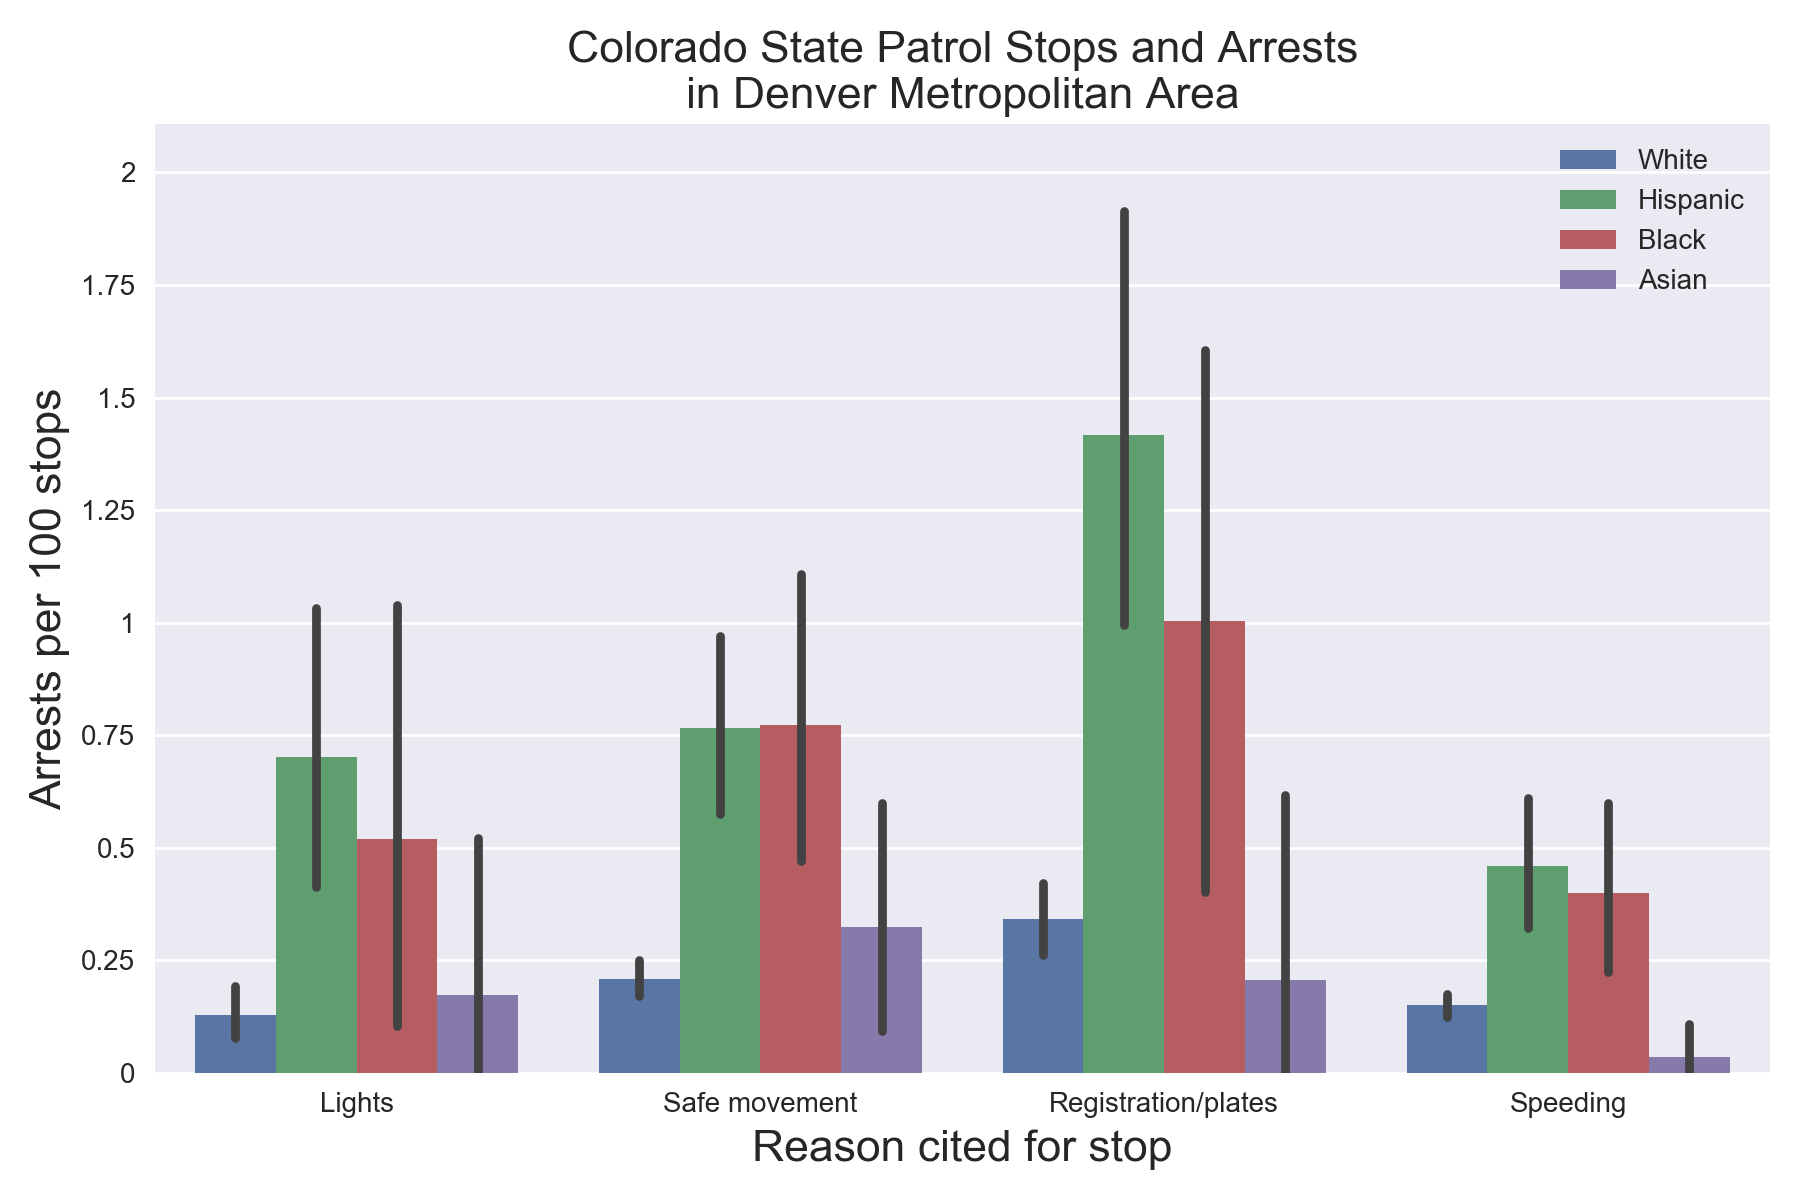

In [209]:
order=['White','Hispanic','Black','Asian']
per100 = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*100))
fp=sns.factorplot(x='violation',y='is_arrested',hue='driver_race',kind='bar',size=6,aspect=1.5,legend=False,hue_order=order,data=denDF,ci=95)
fp.ax.yaxis.set_major_formatter(per100)
fp.ax.set_ylabel("Arrests per 100 stops",fontsize=16)
fp.ax.set_xlabel("Reason cited for stop",fontsize=16)
fp.ax.set_title("Colorado State Patrol Stops and Arrests\nin Denver Metropolitan Area",fontsize=16)
fp.ax.figure.tight_layout()
fp.ax.margins(0.1)
fp.ax.legend()

<IPython.core.display.Javascript object>


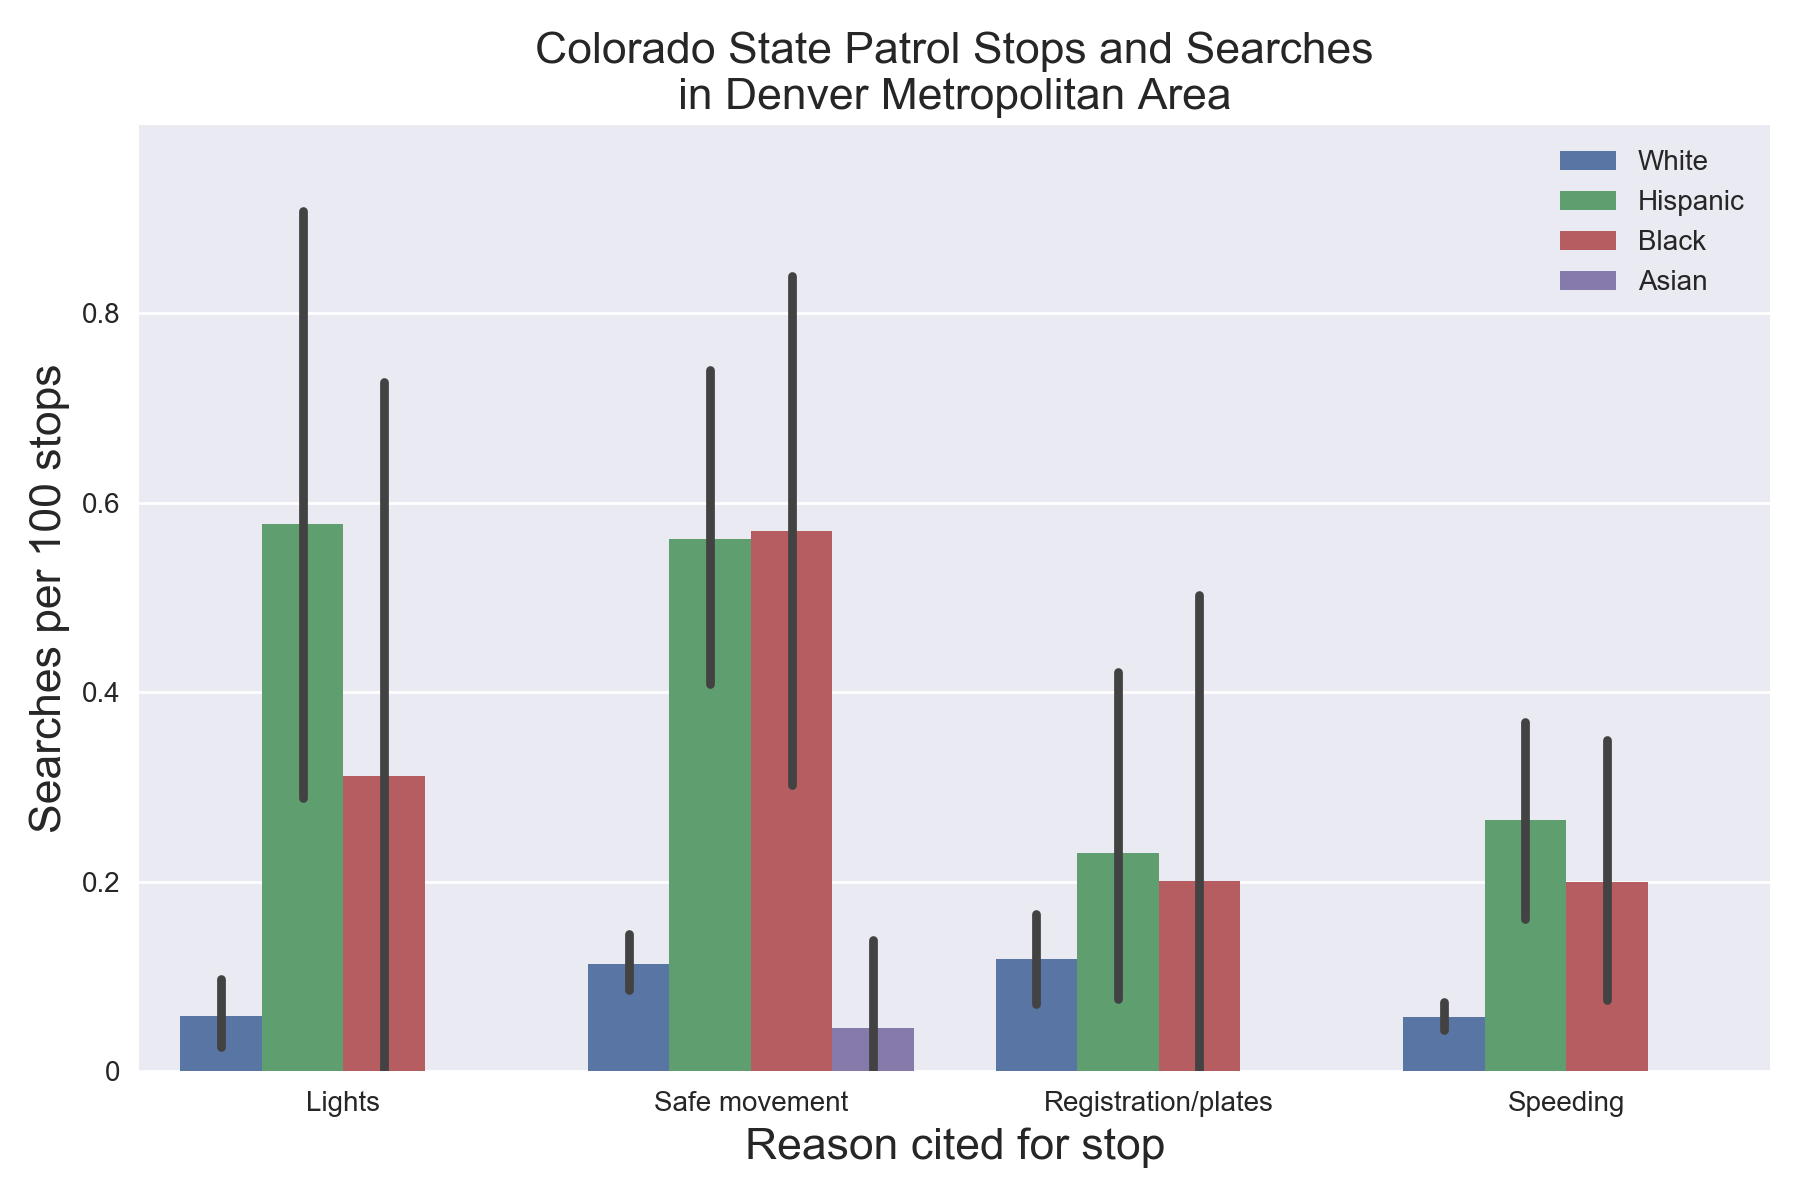

In [223]:
order=['White','Hispanic','Black','Asian']
per100 = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*100))
fp=sns.factorplot(x='violation',y='search_conducted',hue='driver_race',kind='bar',size=6,aspect=1.5,legend=False,hue_order=order,data=denDF,ci=95)
fp.ax.yaxis.set_major_formatter(per100)
fp.ax.set_ylabel("Searches per 100 stops",fontsize=16)
fp.ax.set_xlabel("Reason cited for stop",fontsize=16)
fp.ax.set_title("Colorado State Patrol Stops and Searches\nin Denver Metropolitan Area",fontsize=16)
fp.ax.figure.tight_layout()
fp.ax.margins(0.1)
fp.ax.legend()

In [21]:
boulder_df = df[(df.county_name == 'Boulder County') & (df.driver_race != 'Other')]

In [34]:
boulder_df = boulder_df.dropna(subset=['stop_outcome'])
boulder_df.stop_outcome.value_counts()

Citation           16123
Written Warning    13529
Verbal Warning     10862
Arrest               832
Name: stop_outcome, dtype: int64

In [157]:
dat = pd.DataFrame()
std_err=pd.Series()
for race,rgroup in boulder_df.groupby('driver_race'):
    counts=rgroup.stop_outcome.value_counts()
    dat.loc[:,str(race)] = counts/counts.sum()
    std_err=std_err.append(counts.apply(np.sqrt)/counts.sum())
std_err.index=range(len(std_err))
dat=dat.stack()
dat.name = 'Frequency'
dat=dat.reset_index()
dat.columns=['stop_outcome','race','frequency']
dat.loc[:,'err'] = std_err

In [160]:
# Because seaborn's barplot wont let me do customized errorbars...
# (thank stack overflow:
#  https://stackoverflow.com/questions/42017049/seaborn-how-to-add-error-bars-on-a-grouped-barplot)
def grouped_barplot(df, cat,subcat, val , err):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{}".format(gr), yerr=dfg[err].values)
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    plt.legend()

<IPython.core.display.Javascript object>


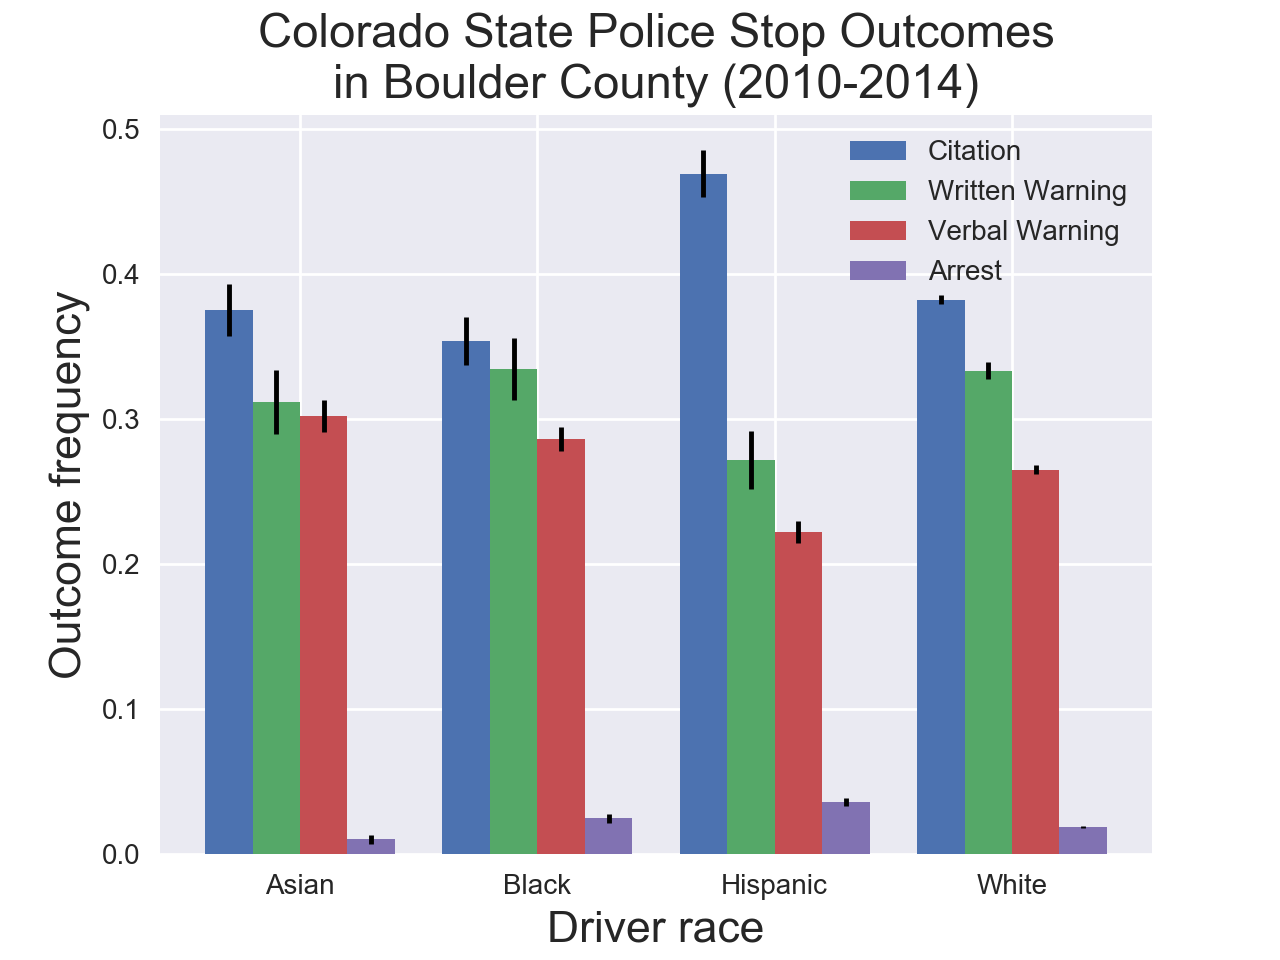

In [189]:
plt.figure()
ax=plt.gca()
grouped_barplot(dat,'race','stop_outcome','frequency','err')
ax.set_xlabel("Driver race",fontsize=16)
ax.set_ylabel("Outcome frequency",fontsize=16)
ax.set_title("Colorado State Police Stop Outcomes\nin Boulder County (2010-2014)",fontsize=17,y=1)